In [14]:
%matplotlib inline

UsageError: Line magic function `%install_ext` not found.



# A 250-hPa Potential Vorticity Hemispheric Map using Python


This example plots a hemispheric plot of GFS 250-hPa Potential Vorticity


In [16]:
# =======
# modules

# time
from datetime import datetime, timedelta
# plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# metpy
import metpy.calc as mpcalc
from metpy.units import units
# netcdf4
from netCDF4 import num2date
# useful 
import numpy as np
import scipy.ndimage as ndimage 
import xarray as xr
from xarray.backends import NetCDF4DataStore
# weather data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS


CPU times: user 111 µs, sys: 26 µs, total: 137 µs
Wall time: 147 µs


In [35]:
# =======
# define Dataset and Time

# Set the time range
now = datetime.utcnow() #current
end = now + timedelta(days=2) # end of forecast
dt = 8 # take only every nth time: 8 x 3h = 1 day

# set geography
north = 90; south = 0; east = 360; west = 0

# define dataset from THREDDS catalog 
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best_gfs = cat.datasets['Best GFS Half Degree Forecast Time Series']
print(best_gfs)

# available THREDDS catalog 
#cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
#print('available THREDDS catalog: ', list(cat.catalog_refs))

Best GFS Half Degree Forecast Time Series


In [177]:
%%time
# =======
# Best GFS Dataset

# Create NCSS object to access the NetcdfSubset
subset_access = best_gfs.subset()

# Query for Best GFS Run

# variables needed for potential vorticity
query = subset_access.query().time_range(now, end).strides(time=dt).lonlat_box(west=west, east=east, south=south, north=north).accept('netcdf4')    # use time(now) to get only current timestep
query.variables('Temperature_isobaric','u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

# Actually getting (request) the data
#data_geopot = ncss.get_data(query_geopot)
#data_wind = ncss.get_data(query_wind)
data = subset_access.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
data = data.metpy.parse_cf()

CPU times: user 461 ms, sys: 103 ms, total: 563 ms
Wall time: 42.7 s


In [195]:
# =======
# Data Retrieval

# available variables
print(sorted(list(data.variables)))

# Grab lat/lon values (GFS will be 1D)
lats = data.lat.values
lons = data.lon.values

# Create a clean datetime object for plotting based on time of forecast
vtime = data.time.data.astype('datetime64[ms]').astype('O')

# Grab the variables
# Need all pressure levels for Temperatures, U and V Wind
press = data['isobaric'][:].values * units('Pa')
temperature = data['Temperature_isobaric'][:]
uwnd = data['u-component_of_wind_isobaric'][:] 
vwnd = data['v-component_of_wind_isobaric'][:] 

# NOTE: different number of vertical pressure levels for temperature(isobaric6) and wind(isobaric)
# print('Shape of Temperature ' + str(temperature.shape) + ' is not equal to shape of wind ' + str(uwnd.shape) + '!')
# remove abundant vertical levels in temperature
# select only where isobaric6 = isobaric
temperature = temperature.metpy.sel(vertical=press)

# Due to a different number of vertical levels find where they are common
#_, _, common_ind = np.intersect1d(uwnd.dimensions[1], lev_temperature.dimensions[1], return_indices=True)


['LatLon_Projection', 'Temperature_isobaric', 'crs', 'isobaric', 'isobaric6', 'lat', 'lon', 'reftime', 'time', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']


In [207]:
# =======
# Calculate Potential Vorticity on all pressure levels

# Compute dx and dy spacing for use in vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# calculate potential temperature theta
theta = mpcalc.potential_temperature(press[None,:, None, None], temperature)

# Comput the PV on all isobaric surfaces
pv = mpcalc.potential_vorticity_baroclinic(theta, press[None, :, None, None], uwnd, vwnd,
                                           dx[None, None, :, :], dy[None, None, :, :],
                                           lats[None, None, :, None] * units('degrees'))

# =======
# Interpolate PV on isentropic or isobaric surface and change unit to PVU

# isobaric
#i250 = list(press.m).index(((250 * units('hPa')).to(press.units)).m)
#pv = pv[:,i250]*1e6

# isentropic
isentlevs = 315 * units.kelvin
isent_anal = mpcalc.isentropic_interpolation(isentlevs, press, temperature.values*units.kelvin, pv*1e6, axis=1)
pv = isent_anal[1]

# Smooth using a gaussian filter from scipy.ndimage
pv, clons = cutil.add_cyclic_point(pv, coord=lons)
pv = ndimage.gaussian_filter(pv[:, :, :], sigma=1, order=0)
print(np.nanmin(pv))
print(np.nanmax(pv))

-0.5679091752566945
7.963011736312657


In [208]:
# =======
# Prepare famous ETH PV colorbar

from matplotlib.colors import from_levels_and_colors
# define levels and colormap
levels = [-1,0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0]
colors = [ # Daniel 11 colors
            [145, 172, 243], #blue
            [176, 198, 235], # light blue
            [211, 228, 235], # white blue
            [245, 220, 177], # white sand
            [233, 192, 140], # dark sand
            [255, 69, 0],      #red
            [250, 122, 0], #orange
            [255,168,0],
            [248, 205, 2], #gold
            [249, 248, 7], #gelb
            [121, 188, 85]   #green
        ]  
# convert RGB values to range between 0 - 1
colors = np.array(colors)/255
# creat colormap
cmap, norm = from_levels_and_colors(levels, colors, extend='neither')


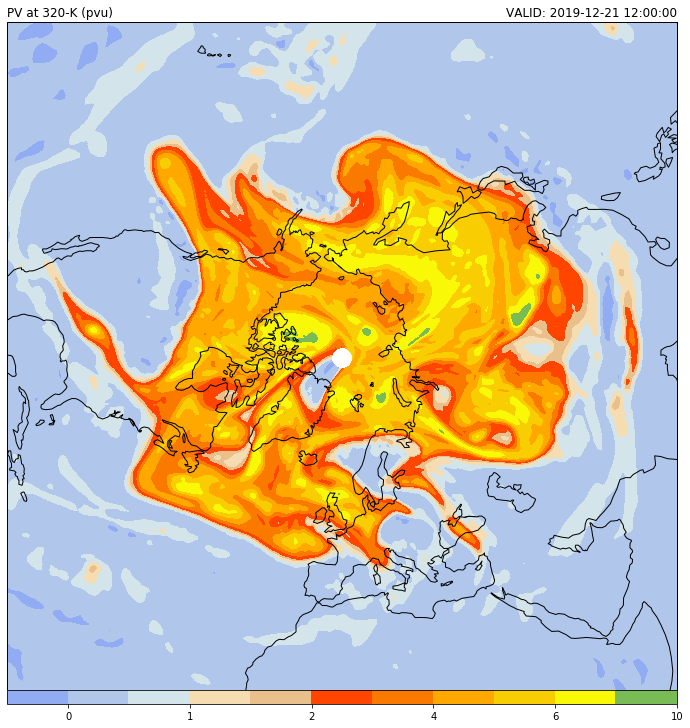

In [209]:
# =======
# Plotting on a map

# Set up the projection
datacrs = ccrs.PlateCarree()                           # projecetion of the data
plotcrs = ccrs.NorthPolarStereo(central_longitude=0.0) # wanted projection

# Make a grid of lat/lon values to use for plotting with Basemap.
clon, clat = np.meshgrid(clons, lats)

fig = plt.figure(1, figsize=(12., 13.))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                       bottom=.07, top=.99, hspace=0.01, wspace=0.01)

ax = plt.subplot(gs[0], projection=plotcrs)

# ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
ax.coastlines(edgecolor='black', linewidth=1)

cs1 = ax.contourf(clon, clat, pv[0,0], levels=levels, cmap=cmap, norm=norm,
                 transform=datacrs)
cbar = plt.colorbar(cs1, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cbar.set_ticks(levels)

# plot title
ax.set_title('PV at 315-K (pvu)', loc='left')
ax.set_title('VALID: {}'.format(vtime[0]), loc='right')

plt.show()

The next cell sets up the geographic details for the plot that we are going to do later.
This is done using the Cartopy package. We will also bring in some geographic data to
geo-reference the image for us.



0


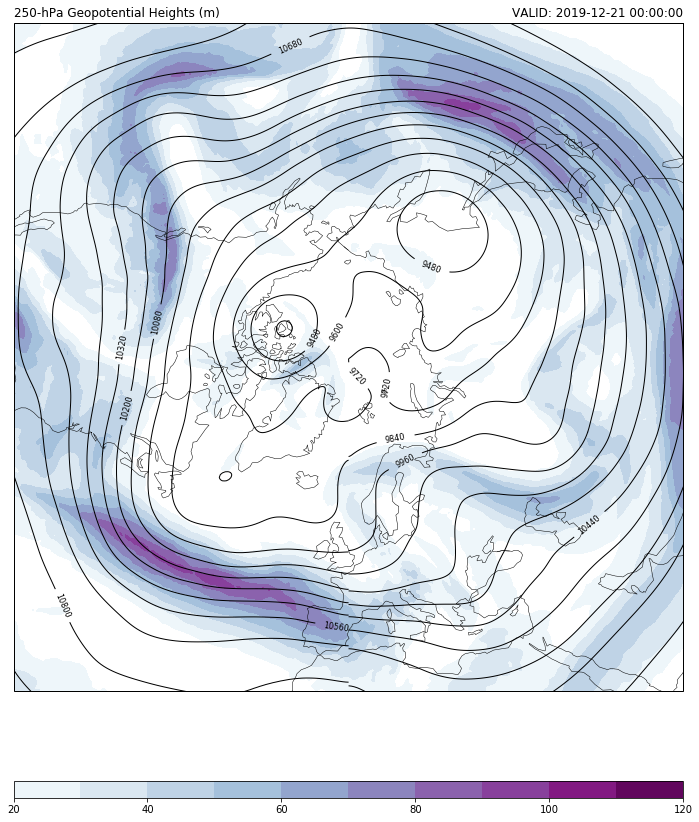

In [26]:
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.NorthPolarStereo(central_longitude=0.0)

# Make a grid of lat/lon values to use for plotting with Basemap.
lons, lats = np.meshgrid(lon, lat)

for iii in range(0,len(times),7):
    print(iii)
    fig = plt.figure(1, figsize=(12., 13.))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                           bottom=.07, top=.99, hspace=0.01, wspace=0.01)

    ax = plt.subplot(gs[0], projection=plotcrs)
    ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
    ax.set_title('VALID: {}'.format(vtimes[iii]), loc='right')

    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines(edgecolor='black', linewidth=0.5)

    clev250 = np.arange(9000, 12000, 120)
    cs = ax.contour(lons, lats, Z_250[iii,:,:], clev250, colors='k',
                    linewidths=1.0, linestyles='solid', transform=datacrs)
    plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
               rightside_up=True, use_clabeltext=True)

    clevsped250 = np.arange(20, 130, 10)
    cmap = plt.cm.get_cmap('BuPu')
    cf = ax.contourf(lons, lats, wspd250[iii,:,:], clevsped250, cmap=cmap, transform=datacrs)
    cax = plt.subplot(gs[1])
    cbar = plt.colorbar(cf, cax=cax, orientation='horizontal', extend='max', extendrect=True)

    plt.savefig('../figures/test' + str(iii) + '.png')



In [159]:
# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
ncss = cat.latest.subset()

# Find the start of the model run and define time range
start_time = ncss.metadata.time_span['begin']
start = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%Sz')
end = start + timedelta(hours=9)

# Query for Latest GFS Run
gfsdata = ncss.query().time_range(start, end).accept('netcdf4')

gfsdata.variables('Temperature_isobaric',
                  'u-component_of_wind_isobaric',
                  'v-component_of_wind_isobaric',
                  'Relative_humidity_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata.lonlat_box(-150, -50, 15, 65)

# Actually getting the data
data = ncss.get_data(gfsdata)

dtime = data.variables['Temperature_isobaric'].dimensions[0]
dlev_hght = data.variables['Temperature_isobaric'].dimensions[1]
dlev_uwnd = data.variables['u-component_of_wind_isobaric'].dimensions[1]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev_hght = data.variables[dlev_hght][:] * units.Pa
lev_uwnd = data.variables[dlev_uwnd][:] * units.Pa
# Due to a different number of vertical levels find where they are common
_, _, common_ind = np.intersect1d(lev_uwnd, lev_hght, return_indices=True)
times = data.variables[dtime]
vtimes = num2date(times[:], times.units)
temps = data.variables['Temperature_isobaric']
tmp = temps[:, common_ind, :, :] * units.kelvin
uwnd = data.variables['u-component_of_wind_isobaric'][:] * units.meter / units.second
vwnd = data.variables['v-component_of_wind_isobaric'][:] * units.meter / units.second
relh = data.variables['Relative_humidity_isobaric'][:]

In [174]:
print(pv)

[[[[            nan             nan             nan ...             nan                nan             nan]   [ 8.53840440e-02  8.53841457e-02  8.53838884e-02 ...  8.53377519e-02     8.53378118e-02  8.53842947e-02]   [ 4.09010517e-02  4.63045617e-02  5.18033625e-02 ...  4.60258026e-02     4.90304770e-02  4.90301712e-02]   ...   [-8.81151788e-04 -7.66263973e-04 -8.70019677e-04 ... -9.97178147e-04    -9.65096078e-04 -8.61831622e-04]   [-9.44142779e-04 -1.04874399e-03 -9.23216943e-04 ... -1.07980600e-03    -9.71002355e-04 -1.06770583e-03]   [-1.37432666e-03 -1.05664392e-03 -7.58834463e-04 ... -7.16951818e-04    -1.06772459e-03 -1.55004329e-03]]  [[            nan             nan             nan ...             nan                nan             nan]   [ 4.45743630e-02  4.45742422e-02  4.45742401e-02 ...  4.45184090e-02     4.45466593e-02  4.45466572e-02]   [ 2.08773046e-02  2.40865580e-02  2.56918578e-02 ...  2.40585500e-02     2.56358701e-02  2.56638803e-02]   ...   [-3.41835361e-04 -5.4

In [167]:
print(temperature.values*units.kelvin)

[[[[242.72952 242.72952 242.72952 ... 242.72952 242.72952 242.72952]   [242.72952 242.72952 242.72952 ... 242.72952 242.72952 242.72952]   [242.92952 242.92952 242.92952 ... 242.92952 242.92952 242.92952]   ...   [266.5295  266.5295  266.5295  ... 267.22952 267.12952 266.72952]   [266.82953 266.4295  266.0295  ... 267.22952 267.12952 266.9295 ]   [266.12952 265.62952 265.32953 ... 267.12952 267.0295  266.62952]]  [[225.6041  225.6041  225.6041  ... 225.6041  225.6041  225.6041 ]   [224.6041  224.6041  224.6041  ... 224.6041  224.6041  224.6041 ]   [223.5041  223.5041  223.5041  ... 223.5041  223.5041  223.5041 ]   ...   [253.7041  253.7041  253.7041  ... 252.80411 252.9041  253.30411]   [253.80411 254.0041  254.30411 ... 252.80411 253.1041  253.4041 ]   [254.1041  254.4041  254.6041  ... 253.2041  253.30411 253.7041 ]]  [[214.11833 214.11833 214.11833 ... 214.11833 214.11833 214.11833]   [212.91833 212.91833 212.91833 ... 212.91833 212.91833 212.91833]   [211.61833 211.61833 211.61833 